In [4]:
import pandas as pd
import numpy as np
from pandas_datareader import data
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from __future__ import division
import datetime
start=datetime.datetime(2012,1,1)

end=datetime.datetime(2017,12,31)
ticker=['BIDU','MSFT','AAPL','TXN']
datas=data.DataReader(ticker, 'morningstar',start, end)

datas.head()

Close    High     Low    Open   Volume
Symbol Date                                               
BIDU   2012-01-02  116.47  116.47  116.47  116.47        0
       2012-01-03  124.29  125.14  120.00  120.23  7314087
       2012-01-04  121.99  123.60  121.15  122.78  4401704
       2012-01-05  123.27  124.00  120.68  121.10  4774484
       2012-01-06  121.09  124.11  120.00  123.72  4980754

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report

# Feature construction

We begin by  the constructing a dataset that contains the predictors which will be used to make the predictions, and the output variable.

Our dataset is built using raw data comprising of a 5-year price series for four different stocks. The individual stocks and index data consists of Date, Open, High, Low, Close and Volume. Using this data we calculated our indicators based on various technical indicators i.e. Exponential Moving Average, Stochastic Oscillator %K and %D, Relative Strength Index(RSI), Rate Of Change(ROC), Momentum (MOM).


In [6]:
# Initialize the `signals` DataFrame with the `signal` column
datas['signal'] = 0.0

# Create short simple moving average over the short window
datas['short_mavg'] = datas['Close'].rolling(window=30, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
datas['long_mavg'] = datas['Close'].rolling(window=120, min_periods=1, center=False).mean()

# Create signals
datas['signal'] = np.where(datas['short_mavg'] > datas['long_mavg'], 1.0, 0.0)   

In [7]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
datas['EMA21'] = EMA(datas, 21)
datas['EMA63'] = EMA(datas, 63)
datas['EMA252'] = EMA(datas, 252)
datas.head()

#calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
datas['ROC21'] = ROC(datas['Close'], 21)
datas['ROC63'] = ROC(datas['Close'], 63)

#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM
datas['MOM21'] = MOM(datas['Close'], 21)
datas['MOM63'] = MOM(datas['Close'], 63)

#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = pd.stats.moments.ewma(u, com=period-1, adjust=False) / \
 pd.stats.moments.ewma(d, com=period-1, adjust=False)
 return 100 - 100 / (1 + rs)
datas['RSI21'] = RSI(datas['Close'], 21)
datas['RSI63'] = RSI(datas['Close'], 63)
datas['RSI252'] = RSI(datas['Close'], 252)

#calculation of stochastic osillator.

def STOK(close, low, high, n): 
 STOK = ((close - pd.rolling_min(low, n)) / (pd.rolling_max(high, n) - pd.rolling_min(low, n))) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - pd.rolling_min(low, n)) / (pd.rolling_max(high, n) - pd.rolling_min(low, n))) * 100
 STOD = pd.rolling_mean(STOK, 3)
 return STOD
datas['%K21'] = STOK(datas['Close'], datas['Low'], datas['High'], 21)
datas['%D21'] = STOD(datas['Close'], datas['Low'], datas['High'], 21)
datas['%K63'] = STOK(datas['Close'], datas['Low'], datas['High'], 63)
datas['%D63'] = STOD(datas['Close'], datas['Low'], datas['High'], 63)
datas['%K252'] = STOK(datas['Close'], datas['Low'], datas['High'], 252)
datas['%D252'] = STOD(datas['Close'], datas['Low'], datas['High'], 252)

C:\Users\Mathilde\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,com=20,min_periods=0,adjust=False).mean()
C:\Users\Mathilde\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,com=62,min_periods=0,adjust=False).mean()
C:\Users\Mathilde\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,com=251,min_periods=0,adjust=False).mean()
C:\Users\Mathilde\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: FutureWarning: pd.rolling_min is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=21).min()
C:\Users\Mathilde\Anacon

In [8]:
#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
datas['MA21'] = MA(datas, 21)
datas['MA63'] = MA(datas, 63)
datas['MA252'] = MA(datas, 252)
datas.tail()

Close    High       Low    Open   Volume  signal  \
Symbol Date                                                            
TXN    2017-12-25  104.13  104.13  104.1300  104.13        0     1.0   
       2017-12-26  104.15  104.19  103.0600  103.58  1473786     1.0   
       2017-12-27  104.53  104.90  103.9800  104.42  1775553     1.0   
       2017-12-28  104.82  104.92  104.2194  104.92  1910723     1.0   
       2017-12-29  104.44  105.08  104.4200  104.58  2813291     1.0   

                   short_mavg  long_mavg       EMA21      EMA63    ...      \
Symbol Date                                                        ...       
TXN    2017-12-25   99.332000  89.956917  100.792764  96.397859    ...       
       2017-12-26   99.571667  90.166167  101.097968  96.640113    ...       
       2017-12-27   99.830333  90.366250  101.409971  96.886672    ...       
       2017-12-28  100.047000  90.568583  101.719973  97.134589    ...       
       2017-12-29  100.270333  90.755583  101.967248  97.362883    ...       

                      RSI252       %K21       %D21       %K63       %D63  \
Symbol Date                                                                
TXN    2017-12-25  58.972992  88.689915  88.501414  92.932862  93.006965   
       2017-12-26  58.978385  88.878417  88.752749  92.733990  92.933955   
       2017-12-27  59.080982  92.459943  90.009425  95.006242  93.557698   
       2017-12-28  59.159246  95.193214  92.177191  96.778269  94.839500   
       2017-12-29  59.010762  91.611687  93.088281  94.349206  95.377906   

                       %K252      %D252        MA21       MA63      MA252  
Symbol Date                                                                
TXN    2017-12-25  96.348144  96.287279   99.868571  96.790635  84.132361  
       2017-12-26  96.249205  96.315164  100.131429  97.020794  84.251409  
       2017-12-27  97.457088  96.684812  100.371905  97.257143  84.371210  
       2017-12-28  98.378894  97.361729  100.750000  97.497937  84.491131  
       2017-12-29  97.171011  97.668998  101.090476  97.728095  84.607163  

[5 rows x 27 columns]

In [9]:
#Dealing with rows that contain NAN

datas.isnull().sum()
datasub=datas.dropna()
datasub.isnull().sum()
datasub.head()

Close      High    Low    Open   Volume  signal  \
Symbol Date                                                             
BIDU   2012-12-20   99.8400  100.9499  98.13  100.73  4184186     0.0   
       2012-12-21   98.7000   99.3000  97.01   97.59  3280627     0.0   
       2012-12-24   96.7700   98.4600  96.10   97.85  1852583     0.0   
       2012-12-25   96.7700   96.7700  96.77   96.77        0     0.0   
       2012-12-26  101.4454  102.5000  96.49   96.49  5019265     0.0   

                   short_mavg   long_mavg      EMA21       EMA63     ...      \
Symbol Date                                                          ...       
BIDU   2012-12-20   95.324303  110.074300  96.513457  102.111690     ...       
       2012-12-21   95.156637  109.930883  96.712234  102.005042     ...       
       2012-12-24   94.895637  109.794217  96.717485  101.841399     ...       
       2012-12-25   94.834607  109.689800  96.722259  101.682873     ...       
       2012-12-26   95.097197  109.627512  97.151636  101.675449     ...       

                      RSI252       %K21       %D21       %K63       %D63  \
Symbol Date                                                                
BIDU   2012-12-20  48.424487  87.626263  91.202471  44.430218  43.844644   
       2012-12-21  48.319300  80.429293  86.787037  40.781050  44.004695   
       2012-12-24  48.141556  68.244949  78.766835  34.603073  39.938114   
       2012-12-25  48.141556  68.244949  72.306397  34.603073  36.662399   
       2012-12-26  48.603220  93.623942  76.704614  50.212062  39.806069   

                       %K252      %D252       MA21        MA63       MA252  
Symbol Date                                                                 
BIDU   2012-12-20  20.354891  20.086621  94.905314  103.682573  120.643246  
       2012-12-21  18.683091  20.159945  95.165314  103.463287  120.550825  
       2012-12-24  15.852764  18.296915  95.191505  103.218525  120.445667  
       2012-12-25  15.852764  16.796207  95.254362  102.935589  120.349159  
       2012-12-26  22.709195  18.138241  95.584143  102.690437  120.275073  

[5 rows x 27 columns]

In [10]:
#excluding columns that are not needed for our prediction.

datasubs=datasub.drop(['Close','High','Low','Open', 'Volume','short_mavg','long_mavg'], axis=1)
datasubs.head()

signal      EMA21       EMA63      EMA252     ROC21  \
Symbol Date                                                              
BIDU   2012-12-20     0.0  96.513457  102.111690  113.818032  7.078507   
       2012-12-21     0.0  96.712234  102.005042  113.680324  2.577427   
       2012-12-24     0.0  96.717485  101.841399  113.526475  1.382923   
       2012-12-25     0.0  96.722259  101.682873  113.374207  2.380449   
       2012-12-26     0.0  97.151636  101.675449  113.265937  5.881849   

                       ROC63   MOM21    MOM63      RSI21      RSI63  \
Symbol Date                                                           
BIDU   2012-12-20 -11.265165  6.6000 -13.3400  51.120665  46.576488   
       2012-12-21 -12.024245  5.4600 -13.8150  49.486404  46.124879   
       2012-12-24 -15.554780  0.5500 -15.4200  46.825384  45.368137   
       2012-12-25 -17.212764  1.3200 -17.8250  46.825384  45.368137   
       2012-12-26 -10.042210  6.9254 -15.4446  53.503077  47.521672   

                      RSI252       %K21       %D21       %K63       %D63  \
Symbol Date                                                                
BIDU   2012-12-20  48.424487  87.626263  91.202471  44.430218  43.844644   
       2012-12-21  48.319300  80.429293  86.787037  40.781050  44.004695   
       2012-12-24  48.141556  68.244949  78.766835  34.603073  39.938114   
       2012-12-25  48.141556  68.244949  72.306397  34.603073  36.662399   
       2012-12-26  48.603220  93.623942  76.704614  50.212062  39.806069   

                       %K252      %D252       MA21        MA63       MA252  
Symbol Date                                                                 
BIDU   2012-12-20  20.354891  20.086621  94.905314  103.682573  120.643246  
       2012-12-21  18.683091  20.159945  95.165314  103.463287  120.550825  
       2012-12-24  15.852764  18.296915  95.191505  103.218525  120.445667  
       2012-12-25  15.852764  16.796207  95.254362  102.935589  120.349159  
       2012-12-26  22.709195  18.138241  95.584143  102.690437  120.275073

# Understanding the dataset using numbers and visuals
The most significant pre-requisite for predictive modeling is to have a good understanding of the dataset. The understanding helps in: Data transforms Choosing the right machine learning algorithms Explains the results obtained from the model Improves its accuracy We would like to see if we have a balanced data or not. And also visualize the correlation between the various features.

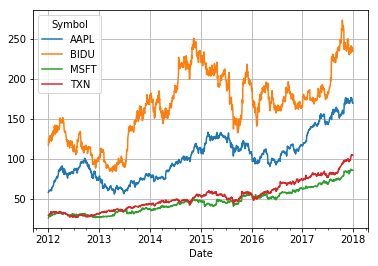

upward  66.82204095222241% out of 6007 total datasize


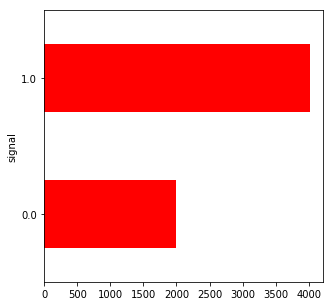

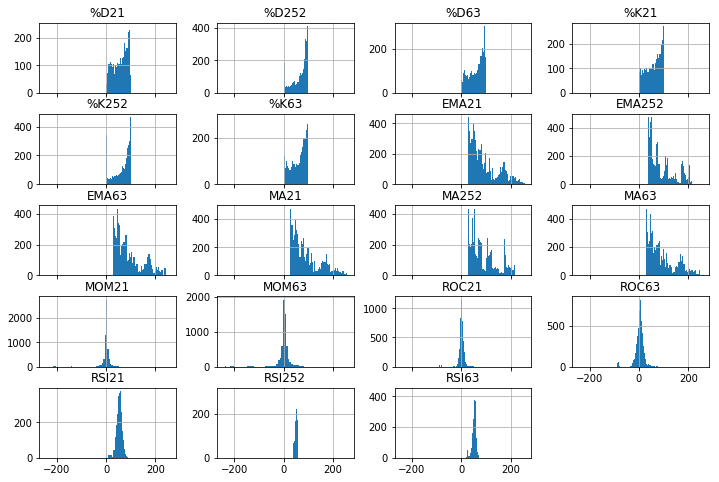

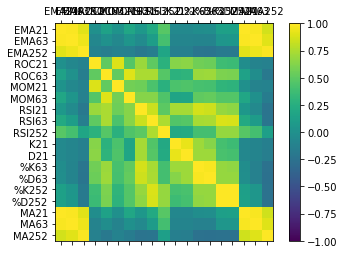

In [11]:
daily_close_px = datas[['Close']].reset_index().pivot('Date', 'Symbol', 'Close')
daily_close_px.plot(grid=True)
plt.show()

fig = plt.figure()
fig.set_size_inches(5,5)
data_s = datasubs.groupby(['signal']).size()
names=['EMA21','EMA63','EMA252','ROC21','ROC63','MOM21','MOM63','RSI21','RSI63','RSI252','K21','D21','%K63','%D63','%K252','%D252','MA21','MA63','MA252']

print("upward  {}% out of {} total datasize".format(100* data_s[1]/(data_s[1]+data_s[0]), data_s[1]+data_s[0]))
plot = data_s.plot(kind='barh', color='red')
X=datasubs.drop(['signal'], axis=1)
y=datasubs['signal']

# Plot the distributions of each input variable 
X.hist(bins=50, sharex=True, figsize=(12,8))

plt.show()


correlations = X.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,19,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

# Feature selection
Feature selection is the process of selecting a subset of features that are most relevant for model construction which aid in creating an accurate predictive model. There are a wide range of feature selection algorithms, and these mainly fall in one of the three categories:

Filter method– selects features by assigning a score to them using some statistical measure. Wrapper method– evaluates different subset of features, and determines the best subset. Embedded method – This method figures out which of the features give the best accuracy while the model is being trained.

In our model, we will use filter method utilising the random.forest.importance function. The random.forest.importance function rates the importance of each feature in the classification of the outcome, i.e. class variable. The function returns a data frame containing the name of each attribute and the importance value based on the mean decrease in accuracy.

In [12]:
forest = RandomForestClassifier(n_estimators=500,random_state=1,n_jobs=-1)
forest.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

        Importance
EMA21     2.143763
RSI21     2.246916
EMA63     2.282470
%K21      2.334897
%D21      2.447479
MA21      2.454393
MA63      2.454992
MOM21     2.522991
%K63      2.659367
EMA252    2.774269
MA252     3.106138
ROC21     3.185368
RSI252    3.507886
%D63      3.666679
%K252     9.167479
RSI63    11.151801
%D252    11.400691
ROC63    14.600115
MOM63    15.892306


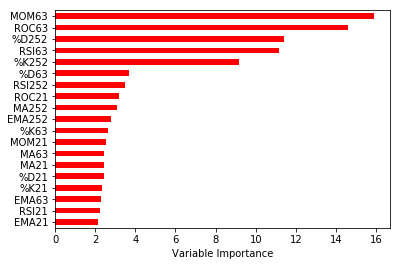

In [13]:
Importance = pd.DataFrame({'Importance':forest.feature_importances_*100}, index=X.columns)
print(Importance.sort_values('Importance', axis=0, ascending=True))
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm,neighbors
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Splitting
After creating models for unseen data, we will check their accuracy thanks to statistical methods. We evaluate the accuracy of the best model on actual unseen data to have the estimation more concrete.
Meaning that we will use the algorithm on the training set and use the model on the test set afterwards for validation. We split the dataset into 80% training set and 20% test set.

In [15]:
X_1=datasub.drop(['signal'],axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X_1, y, test_size=0.2, random_state=1)
print (X_train.shape, Y_train.shape)
print (X_test.shape, Y_test.shape)
from sklearn.preprocessing import RobustScaler
X_train_1=X_train.drop(['Close','High','Low','Open', 'Volume','short_mavg','long_mavg'], axis=1)
X_test_1=X_test.drop(['Close','High','Low','Open', 'Volume','short_mavg','long_mavg'], axis=1)

rs = RobustScaler()
rs.fit(X_train_1)
X_train_std = rs.transform(X_train_1)
X_test_std = rs.transform(X_test_1)

(4805, 26) (4805,)
(1202, 26) (1202,)


# Modeling
In order to know which algorithm technic is the best for our strategy, we evaluate 5 non linear different methods:
- K-Nearest Neighbors (KNN)
- Classification and Regression Trees (CART)
- Support Vector Machines (SVM)
- Random Forest (RF)
- Gaussian Naïve Bayes (NB)

To ensure the comparatibility of the results (use the same data splits), the random number (seed = 1) is reset before each run.

In [16]:
# Spot Check Algorithms
data_Selected = []
data_Selected.append(('KNN', KNeighborsClassifier()))
data_Selected.append(('CART', DecisionTreeClassifier()))
data_Selected.append(('SVM', SVC()))
data_Selected.append(('RF', RandomForestClassifier()))
data_Selected.append(('NB', GaussianNB()))
# evaluate each model in turn
results = []
names = []
score=['f1','accuracy','precison','recall']
for name, model in data_Selected:
    kfold = model_selection.KFold(n_splits=10, random_state=1)
    cv_results =cross_val_score(model, X_train_std, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    output = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(output)

KNN: 0.957338 (0.004066)
CART: 0.946096 (0.008351)
SVM: 0.932570 (0.008892)
RF: 0.967742 (0.005758)
NB: 0.830599 (0.012240)


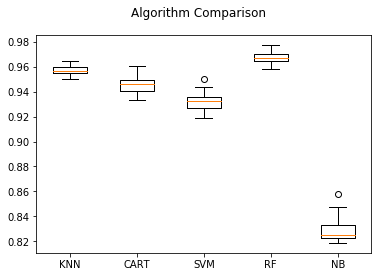

In [17]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [18]:
rf = RandomForestClassifier(n_estimators=500, min_samples_split=5,min_samples_leaf =2,max_features = 10,n_jobs=4,criterion='gini')
predy=rf.fit(X_train_std, Y_train)

In [19]:
predr= rf.predict(X_test_std)

In [20]:
print(accuracy_score(Y_test, predr))
print(confusion_matrix(Y_test, predr))
print(classification_report(Y_test, predr))

0.9658901830282862
[[391  19]
 [ 22 770]]
             precision    recall  f1-score   support

        0.0       0.95      0.95      0.95       410
        1.0       0.98      0.97      0.97       792

avg / total       0.97      0.97      0.97      1202



In [21]:
import itertools
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix,f1_score

def pltcm(ax, y_test, y_pred, classes, title, th=0.7, cmap=plt.cm.Reds):
    y_pred_labels = (y_pred>th).astype(int)
    
    cm = confusion_matrix(y_test, y_pred_labels)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tickmarks = np.arange(len(classes))
    ax.set_xticks(tickmarks)
    ax.set_yticks(tickmarks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="green" if cm[i, j] > thresh else "yellow")
    ax.set_ylabel('Actual')
    ax.set_xlabel('Prediction')

def pltauc(ax, y_train, y_pred, y_test, y_tpred, th=0.7):

    y_predl = (y_pred>th).astype(int)
    y_tpredl  = (y_tpred>th).astype(int)

    fpr_tr, tpr_tr, _ = roc_curve(y_train,y_pred)
    roc_auc_tr = auc(fpr_tr, tpr_tr)
    acc_tr = accuracy_score(y_train, y_predl)

    fpr_ts, tpr_ts, _ = roc_curve(y_test,y_tpred)
    roc_auc_ts = auc(fpr_ts, tpr_ts)
    acc_ts = accuracy_score(y_test, y_tpredl)

    ax.plot(fpr_tr, tpr_tr)
    ax.plot(fpr_ts, tpr_ts)

    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    
    train_text = 'train acc = {:.3f}, auc = {:.2f}'.format(acc_tr, roc_auc_tr)
    test_text = 'test acc = {:.3f}, auc = {:.2f}'.format(acc_ts, roc_auc_ts)
    ax.legend([train_text, test_text])

def result(es,threshold,X_train,X_test,y_train,y_test):
    y_pred = es.predict(X_train)
    y_tpred = es.predict(X_test)

    fig,ax = plt.subplots(1,3)
    fig.set_size_inches(15,5)
    pltcm(ax[0],  y_train, y_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
    pltcm(ax[1],  y_test, y_tpred,   [0,1], 'Confusion matrix (TEST)', threshold)
    pltauc(ax[2], y_train, y_pred, y_test, y_tpred, threshold)
    plt.tight_layout()
    plt.show()
    
def btf1(es,X_test,y_test):
    thresholds = np.linspace(0.3,0.6,100)
    y_tpred = es.predict(X_test)
    score_set = []
    index_threshold = 0
    sum_score = 0
    for threshold in thresholds:
        y_tpred1  = (y_tpred > threshold).astype(int)
        score = f1_score(y_test, y_tpred1)
        score_set.append(score)
    for i in range(95):
        temp = sum(score_set[i:i+5])
        if temp > sum_score:
            sum_score = temp
            index_threshold = i+2 # the average threshold
    return thresholds[index_threshold],sum_score/5

def testf1(es,bestthreshold,X_test,y_test):
    y_tpred = es.predict(X_test)
    y_tpred1  = (y_tpred > bestthreshold).astype(int)
    score = f1_score(y_test, y_tpred1)
    return score

test f1: 0.974067046173308 train f1: 0.9987596899224804


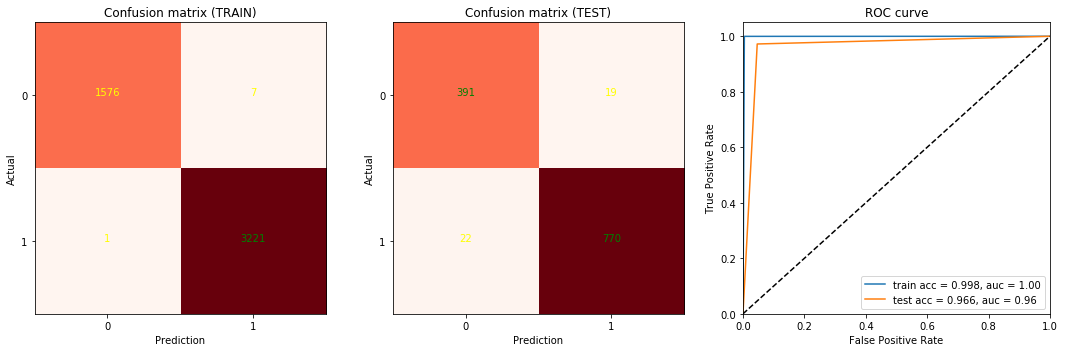

In [22]:
bestthreshold,bestf1 = btf1(rf,X_train_std, Y_train)
testf1 = testf1(rf,bestthreshold,X_test_std,Y_test)
print('test f1:',testf1,'train f1:',bestf1)
result(rf,bestthreshold,X_train_std,X_test_std, Y_train,Y_test)

signal_pred  signal_actual  Market Returns  Actual Returns  \
Symbol Date                                                                     
TXN    2013-09-16          1.0            1.0             NaN             NaN   
AAPL   2013-05-22          0.0            0.0        0.558729        0.558729   
MSFT   2015-09-04          0.0            1.0       -0.324194       -0.000000   
       2012-05-17          0.0            0.0       -0.302511       -0.302511   
TXN    2015-11-19          1.0            1.0        0.949865        0.000000   

                   Strategy Returns  
Symbol Date                          
TXN    2013-09-16               NaN  
AAPL   2013-05-22          0.558729  
MSFT   2015-09-04         -0.000000  
       2012-05-17         -0.000000  
TXN    2015-11-19          0.000000

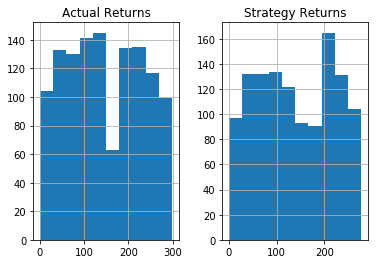

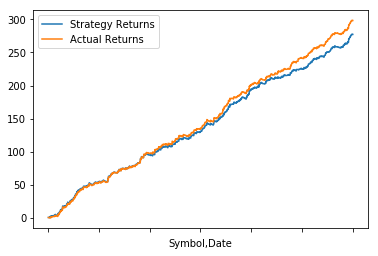

In [24]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata = pd.DataFrame(index=X_test.index)
backtestdata['signal_pred'] = predr
backtestdata['signal_actual'] = Y_test
backtestdata['Market Returns'] = X_test['Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()
backtestdata.head()

# Conclusion
    Based on the return from our strategy, we do not deviate that much from the actual market return. Indeed, the achieved momentum trading strategy made us well predict the stock prices direction to invest/desinvest in order to make profits. However, as our accuracy is not 100% (but more than 96%) therefore, we made relatively few losses compared to the actual returns. 